# Multimodal RAG with Gemini
This notebook demonstrates how to use Google's Gemini API for multimodal retrieval-augmented generation (RAG) with text and images.

In [1]:
# Import Required Libraries
import requests
from PIL import Image
import io
import base64
import os
import google.generativeai as genai
from transformers import CLIPProcessor, CLIPModel


f:\Datascience_projects\Multi_Model_RAG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Authenticate and Initialize Gemini API
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel('gemma-3-12b-it')


In [3]:
### initialize the Clip Model for unified embeddings
clip_model=CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor=CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]



CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [4]:
### Embedding functions
def embed_image(image_data):
    """Embed image using CLIP"""
    if isinstance(image_data, str):  # If path
        image = Image.open(image_data).convert("RGB")
    else:  # If PIL Image
        image = image_data
    
    inputs=clip_processor(images=image,return_tensors="pt")
    with torch.no_grad():
        features = clip_model.get_image_features(**inputs)
        # Normalize embeddings to unit vector
        features = features / features.norm(dim=-1, keepdim=True)
        return features.squeeze().numpy()
    
def embed_text(text):
    """Embed text using CLIP."""
    inputs = clip_processor(
        text=text, 
        return_tensors="pt", 
        padding=True,
        truncation=True,
        max_length=77  # CLIP's max token length
    )
    with torch.no_grad():
        features = clip_model.get_text_features(**inputs)
        # Normalize embeddings
        features = features / features.norm(dim=-1, keepdim=True)
        return features.squeeze().numpy()

In [5]:
import fitz
from langchain.text_splitter import RecursiveCharacterTextSplitter

## Process PDF
pdf_path="multimodal-sample.pdf"
doc=fitz.open(pdf_path)
# Storage for all documents and embeddings
all_docs = []
all_embeddings = []
image_data_store = {}  # Store actual image data for LLM

# Text splitter
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)




In [6]:
doc

Document('multimodal-sample.pdf')

In [7]:
from langchain_core.documents import Document
import torch
for i,page in enumerate(doc):
    ## process text
    text=page.get_text()
    if text.strip():
        ##create temporary document for splitting
        temp_doc = Document(page_content=text, metadata={"page": i, "type": "text"})
        text_chunks = splitter.split_documents([temp_doc])

        #Embed each chunk using CLIP
        for chunk in text_chunks:
            embedding = embed_text(chunk.page_content)
            all_embeddings.append(embedding)
            all_docs.append(chunk)

    ## process images
    ##Three Important Actions:

    ##Convert PDF image to PIL format
    ##Store as base64 for GPT-4V (which needs base64 images)
    ##Create CLIP embedding for retrieval

    for img_index, img in enumerate(page.get_images(full=True)):
        try:
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            
            # Convert to PIL Image
            pil_image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
            
            # Create unique identifier
            image_id = f"page_{i}_img_{img_index}"
            
            # Store image as base64 for later use with GPT-4V
            buffered = io.BytesIO()
            pil_image.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode()
            image_data_store[image_id] = img_base64
            
            # Embed image using CLIP
            embedding = embed_image(pil_image)
            all_embeddings.append(embedding)
            
            # Create document for image
            image_doc = Document(
                page_content=f"[Image: {image_id}]",
                metadata={"page": i, "type": "image", "image_id": image_id}
            )
            all_docs.append(image_doc)
            
        except Exception as e:
            print(f"Error processing image {img_index} on page {i}: {e}")
            continue

doc.close()


In [8]:
all_docs

[Document(metadata={'page': 0, 'type': 'text'}, page_content='Annual Revenue Overview\nThis document summarizes the revenue trends across Q1, Q2, and Q3. As illustrated in the chart\nbelow, revenue grew steadily with the highest growth recorded in Q3.\nQ1 showed a moderate increase in revenue as new product lines were introduced. Q2 outperformed\nQ1 due to marketing campaigns. Q3 had exponential growth due to global expansion.'),
 Document(metadata={'page': 0, 'type': 'image', 'image_id': 'page_0_img_0'}, page_content='[Image: page_0_img_0]')]

In [9]:
import numpy as np

# Create unified FAISS vector store with CLIP embeddings
embeddings_array = np.array(all_embeddings)
embeddings_array

array([[-0.00267245,  0.01282999, -0.05183142, ..., -0.00385085,
         0.02977721, -0.00010685],
       [ 0.01732339, -0.01327691, -0.02427031, ...,  0.08994055,
        -0.00272157,  0.03253039]], shape=(2, 512), dtype=float32)

In [10]:
(all_docs,embeddings_array)

([Document(metadata={'page': 0, 'type': 'text'}, page_content='Annual Revenue Overview\nThis document summarizes the revenue trends across Q1, Q2, and Q3. As illustrated in the chart\nbelow, revenue grew steadily with the highest growth recorded in Q3.\nQ1 showed a moderate increase in revenue as new product lines were introduced. Q2 outperformed\nQ1 due to marketing campaigns. Q3 had exponential growth due to global expansion.'),
  Document(metadata={'page': 0, 'type': 'image', 'image_id': 'page_0_img_0'}, page_content='[Image: page_0_img_0]')],
 array([[-0.00267245,  0.01282999, -0.05183142, ..., -0.00385085,
          0.02977721, -0.00010685],
        [ 0.01732339, -0.01327691, -0.02427031, ...,  0.08994055,
         -0.00272157,  0.03253039]], shape=(2, 512), dtype=float32))

In [11]:
from langchain_community.vectorstores import FAISS

# Create custom FAISS index since we have precomputed embeddings
vector_store = FAISS.from_embeddings(
    text_embeddings=[(doc.page_content, emb) for doc, emb in zip(all_docs, embeddings_array)],
    embedding=None,  # We're using precomputed embeddings
    metadatas=[doc.metadata for doc in all_docs]
)
vector_store

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


In [12]:
# Load and Prepare Multimodal Data
sample_text = "What does the chart show about revenue trends?"
image_path = "image.png"  # Path to your image file

# Load image and convert to base64
with open(image_path, "rb") as img_file:
    image_bytes = img_file.read()
    image_base64 = base64.b64encode(image_bytes).decode()

# Prepare Gemini input (SDK expects PIL Image, REST expects base64)
pil_image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

In [13]:
def retrieve_multimodal(query, k=5):
    """Unified retrieval using CLIP embeddings for both text and images."""
    # Embed query using CLIP
    query_embedding = embed_text(query)
    
    # Search in unified vector store
    results = vector_store.similarity_search_by_vector(
        embedding=query_embedding,
        k=k
    )
    
    return results

In [14]:
from langchain.schema.messages import HumanMessage


def create_multimodal_message(query, retrieved_docs):
    """Create a message with both text and images for GPT-4V."""
    content = []
    
    # Add the query
    content.append({
        "type": "text",
        "text": f"Question: {query}\n\nContext:\n"
    })
    
    # Separate text and image documents
    text_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "text"]
    image_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "image"]
    
    # Add text context
    if text_docs:
        text_context = "\n\n".join([
            f"[Page {doc.metadata['page']}]: {doc.page_content}"
            for doc in text_docs
        ])
        content.append({
            "type": "text",
            "text": f"Text excerpts:\n{text_context}\n"
        })
    
    # Add images
    for doc in image_docs:
        image_id = doc.metadata.get("image_id")
        if image_id and image_id in image_data_store:
            content.append({
                "type": "text",
                "text": f"\n[Image from page {doc.metadata['page']}]:\n"
            })
            content.append({
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{image_data_store[image_id]}"
                }
            })
    
    # Add instruction
    content.append({
        "type": "text",
        "text": "\n\nPlease answer the question based on the provided text and images."
    })
    
    return HumanMessage(content=content)

In [15]:
def multimodal_pdf_rag_pipeline(query):
    """Main pipeline for multimodal RAG."""
    from IPython.display import display
    # Retrieve relevant documents
    context_docs = retrieve_multimodal(query, k=5)

    # Build Gemini-compatible input: list of text and PIL Image objects
    gemini_inputs = []
    # Add the query
    gemini_inputs.append(query)
    # Add text context
    text_docs = [doc for doc in context_docs if doc.metadata.get("type") == "text"]
    if text_docs:
        text_context = "\n\n".join([
            f"[Page {doc.metadata['page']}]: {doc.page_content}"
            for doc in text_docs
        ])
        gemini_inputs.append(f"Text excerpts:\n{text_context}\n")
    # Add images
    image_docs = [doc for doc in context_docs if doc.metadata.get("type") == "image"]
    for doc in image_docs:
        image_id = doc.metadata.get("image_id")
        if image_id and image_id in image_data_store:
            # Decode base64 to bytes and load as PIL Image
            img_bytes = base64.b64decode(image_data_store[image_id])
            pil_image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
            gemini_inputs.append(pil_image)

    # Add instruction
    gemini_inputs.append("Please answer the question based on the provided text and images.")

    # Get response from Gemini
    response = model.generate_content(gemini_inputs)

    # Print retrieved context info
    print(f"\nRetrieved {len(context_docs)} documents:")
    for doc in context_docs:
        doc_type = doc.metadata.get("type", "unknown")
        page = doc.metadata.get("page", "?")
        if doc_type == "text":
            preview = doc.page_content[:100] + "..." if len(doc.page_content) > 100 else doc.page_content
            print(f"  - Text from page {page}: {preview}")
        else:
            print(f"  - Image from page {page}")
            image_id = doc.metadata.get("image_id")
            if image_id and image_id in image_data_store:
                img_bytes = base64.b64decode(image_data_store[image_id])
                pil_image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
                display(pil_image)
    print("\n")

    return response.text if hasattr(response, 'text') else response


Query: What does the chart on page 1 show about revenue trends?
--------------------------------------------------

Retrieved 2 documents:
  - Text from page 0: Annual Revenue Overview
This document summarizes the revenue trends across Q1, Q2, and Q3. As illust...
  - Image from page 0

Retrieved 2 documents:
  - Text from page 0: Annual Revenue Overview
This document summarizes the revenue trends across Q1, Q2, and Q3. As illust...
  - Image from page 0


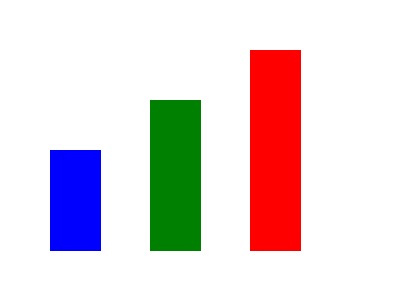



Answer: According to the chart and text, revenue grew steadily across Q1, Q2, and Q3, with the highest growth recorded in Q3. The chart visually represents this with bar heights increasing from blue (Q1) to green (Q2) to red (Q3).

Query: Summarize the main findings from the document
--------------------------------------------------

Retrieved 2 documents:
  - Text from page 0: Annual Revenue Overview
This document summarizes the revenue trends across Q1, Q2, and Q3. As illust...
  - Image from page 0

Retrieved 2 documents:
  - Text from page 0: Annual Revenue Overview
This document summarizes the revenue trends across Q1, Q2, and Q3. As illust...
  - Image from page 0


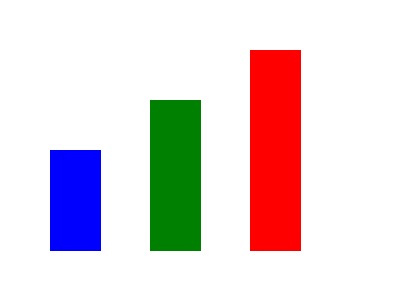



Answer: Here's a summary of the main findings from the document excerpt:

*   **Revenue Growth:** The company experienced steady revenue growth throughout Q1, Q2, and Q3.
*   **Q1 Growth:** Moderate increase driven by the introduction of new product lines.
*   **Q2 Growth:** Outperformed Q1 due to successful marketing campaigns.
*   **Q3 Growth:** Exponential growth was achieved due to global expansion.



The chart visually represents this growth, with Q1 (blue) being the smallest, Q2 (green) larger, and Q3 (red) being the largest.

Query: What visual elements are present in the document?
--------------------------------------------------

Retrieved 2 documents:
  - Text from page 0: Annual Revenue Overview
This document summarizes the revenue trends across Q1, Q2, and Q3. As illust...
  - Image from page 0

Retrieved 2 documents:
  - Text from page 0: Annual Revenue Overview
This document summarizes the revenue trends across Q1, Q2, and Q3. As illust...
  - Image from page 0


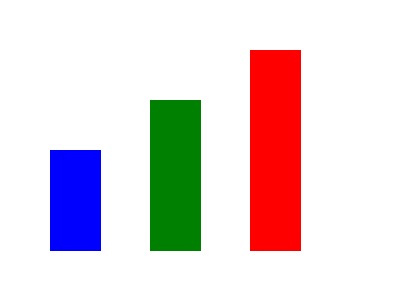



Answer: Based on the provided text and image, the visual element present in the document is a **bar chart**. The text explicitly states "As illustrated in the chart below," and the image shows three vertical bars of different heights, colored blue, green, and red, which is a classic representation of a bar chart.


In [16]:
if __name__ == "__main__":
    # Example queries
    queries = [
        "What does the chart on page 1 show about revenue trends?",
        "Summarize the main findings from the document",
        "What visual elements are present in the document?"
    ]
    
    for query in queries:
        print(f"\nQuery: {query}")
        print("-" * 50)
        answer = multimodal_pdf_rag_pipeline(query)
        print(f"Answer: {answer}")
        print("=" * 70)